In [1]:
import pandas as pd
import numpy as np
import pickle
import sqlalchemy
from utilities.config import *

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
engine = sqlalchemy.create_engine(ALCHEMY+"nat_poc")

In [4]:
vectors_df = pd.read_sql("""SELECT * FROM nat_poc.skill_vectors;""", engine)

### Clustering using K-means

In [7]:
data = np.array(list(zip(*[vectors_df[col] for col in vectors_df.columns[1:]])))

In [9]:
# k means determine k
distortions = []
K = range(1,100)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(data)
    kmeanModel.fit(data)
    distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    if k % 20 == 0:
        print(f"{k} clusters calculated")

20 clusters calculated
40 clusters calculated
60 clusters calculated
80 clusters calculated


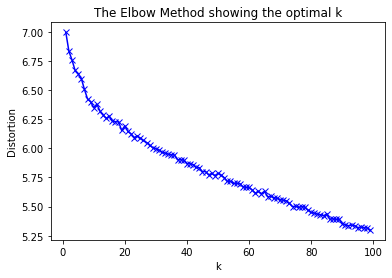

In [10]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [23]:
optimal_k_clusters = 20

In [35]:
kmeanModel = KMeans(algorithm='auto', n_init=20, max_iter=30, n_clusters=optimal_k_clusters, random_state=6868).fit(data)
kmeanModel.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=30,
    n_clusters=20, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=6868, tol=0.0001, verbose=0)

In [36]:
print(len(kmeanModel.labels_))
print(len(data))

2414
2414


In [37]:
k_means_df = vectors_df[['skill']]
k_means_df['label'] = list(kmeanModel.labels_)
k_means_df.sort_values('label', inplace=True, ascending=True)

In [38]:
k_means_df.to_csv("./model_output/k_means_16062022.csv", index=False)

In [39]:
k_means_df.label.value_counts()

1     1478
3      106
8      105
0      103
9      102
13      83
2       78
11      66
18      60
5       58
17      55
19      51
7       36
14      27
16       1
12       1
10       1
6        1
4        1
15       1
Name: label, dtype: int64

##### Extremely poor performance as expected, try reducing number of features with PCA before running K-means

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [47]:
x = vectors_df.iloc[:, 1:].values
x = StandardScaler().fit_transform(x)

In [48]:
x.shape, np.mean(x), np.std(x)

((2414, 200), 8.168003694011094e-19, 1.0)

In [54]:
skill_vec_pca_model = PCA(n_components=20, random_state=6868)
pca_skill_vec = skill_vec_pca_model.fit_transform(x)

In [56]:
pca_skill_vec_df = pd.DataFrame(data=pca_skill_vec, columns=['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6','PC_7','PC_8','PC_9','PC_10','PC_11','PC_12','PC_13','PC_14','PC_15','PC_16','PC_17','PC_18','PC_19','PC_20'])

In [57]:
print(f"Explained variation per principal component: {skill_vec_pca_model.explained_variance_ratio_}")

Explained variation per principal component: [0.0623292  0.0462702  0.04167611 0.03669464 0.03129572 0.02837081
 0.02647923 0.02359577 0.01910051 0.01888143 0.0185599  0.01634597
 0.01425976 0.01289395 0.0111601  0.01095237 0.01026484 0.01006355
 0.00997509 0.00964701]


In [58]:
0.0623292 + 0.0462702 + 0.04167611 +0.03669464 +0.03129572 +0.02837081+0.02647923+ 0.02359577 +0.01910051 +0.01888143 +0.0185599 + 0.01634597+0.01425976 +0.01289395+ 0.0111601 + 0.01095237 +0.01026484 +0.01006355+0.00997509 +0.00964701

0.45881616000000003

##### PCA did not help, sum of 20 components only hold less than 50% variance of the 200 features

### Clustering using Spectral

In [62]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

import networkx as nx
import seaborn as sns
sns.set()

#### Visualisation of embedding using T-SNE

In [70]:
x = vectors_df.iloc[:, 1:].values
x_embedded = TSNE(n_components=2, learning_rate=200, init='random', random_state=6868).fit_transform(x)
x_embedded.shape

(2414, 2)

In [139]:
tsne_df = pd.DataFrame()

In [147]:
pc_1_list = []
pc_2_list = []
for i in range(2414):
    pc_1 = x_embedded[i][0]
    pc_2 = x_embedded[i][1]
    pc_1_list += [pc_1]
    pc_2_list += [pc_2]

In [148]:
tsne_df['skill'] = vectors_df.skill
tsne_df['pc_1'] = pc_1_list
tsne_df['pc_2'] = pc_2_list

In [149]:
tsne_df.head()

,skill,pc_1,pc_2
0,.net,24.441793,-21.529779
1,1password (software),1.242393,-20.726391
2,2d animation,33.694588,13.751719
3,360 degree camera operations,-5.521698,0.904331
4,3d animation,35.498505,15.061076


In [71]:
# Unpickling
with open("./model/nat_job_skill_wordvec.model", "rb") as fp:
    model = pickle.load(fp)

In [125]:
def display_closestwords_tsnescatterplot(model, word, size):
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, learning_rate=200, init='random', random_state=6868)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(5, 0), textcoords='offset points')
        plt.xlim(x_coords.min()-10, x_coords.max()-10)
        plt.ylim(y_coords.min()-10, y_coords.max()-10)
    plt.show()

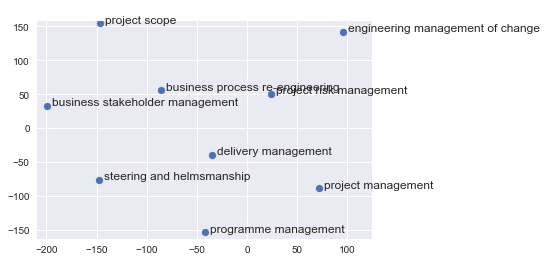

In [161]:
display_closestwords_tsnescatterplot(model, 'project management', 200) 

#### Using Google spectral clustering instead of sklearn

In [84]:
from spectralcluster import SpectralClusterer

In [162]:
def spectral_n_clusterer(n_clusters, data_features):
    clusterer = SpectralClusterer(
    min_clusters=int(n_clusters),
    max_clusters=int(n_clusters)+20,
    autotune=None,
    laplacian_type=None,
    refinement_options=None,
    custom_dist="cosine")
    
    cluster_labels = clusterer.predict(data_features)
    
    spectral_df = vectors_df[['skill']]
    spectral_df['label'] = list(cluster_labels)
    spectral_df.sort_values('label', inplace=True, ascending=True)
    
    return spectral_df

In [166]:
spectral_20_df = spectral_n_clusterer(20, x)
spectral_40_df = spectral_n_clusterer(40, x)
spectral_50_df = spectral_n_clusterer(50, x)
spectral_60_df = spectral_n_clusterer(60, x)

In [168]:
spectral_20_df.to_csv("./model_output/spectral_20_16062022.csv", index=False)
spectral_40_df.to_csv("./model_output/spectral_40_16062022.csv", index=False)
spectral_50_df.to_csv("./model_output/spectral_50_16062022.csv", index=False)
spectral_60_df.to_csv("./model_output/spectral_60_16062022.csv", index=False)

In [169]:
spectral_60_df.label.value_counts()

44    132
12     76
31     70
13     69
8      68
50     67
47     63
38     59
9      58
23     54
10     53
17     51
15     50
40     49
1      46
59     44
30     43
36     42
35     41
46     40
54     40
55     40
3      39
20     39
58     39
14     38
21     37
28     37
16     35
49     35
24     35
53     34
45     34
18     33
19     33
27     33
32     33
4      32
51     32
0      31
29     30
43     29
48     29
57     29
42     29
39     28
37     28
6      28
2      28
5      28
41     27
56     27
11     26
22     26
25     26
34     26
7      25
33     22
52     21
26     18
Name: label, dtype: int64

In [170]:
spectral_60_df.head()

,skill,label
248,badminton,0
974,grep/egrep,0
1457,next.js,0
1458,nginx,0
1503,operational excellence,0


In [171]:
spectral_viz_df = spectral_40_df.merge(tsne_df, how='left', left_on='skill', right_on='skill')

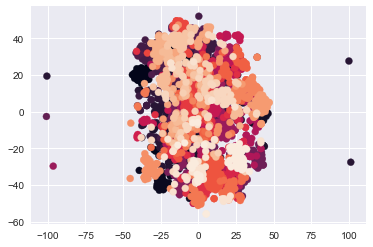

In [172]:
plt.scatter(x=spectral_viz_df.pc_1, y=spectral_viz_df.pc_2, c=spectral_viz_df.label)
plt.show()